# Even Study Analysis

In [122]:
import pandas as pd 

import numpy as np 
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandas.api import types

from linearmodels import PanelOLS


In [123]:
data = pd.read_csv("src/did_training_productivity.csv", index_col = 0)
# standardize the periods so as to have period 13 as 0, as period 13 represents the start of the treatment
data["period"] -= 13

Estimate the dynamic DiD specification:

$$Y_{it} = \alpha_i + \delta_t + \sum_{\tau=-k}^{-2} \delta_{\tau} W_{it}^{\tau} + \sum_{\tau=0}^{m} \delta_{\tau} W_{it}^{\tau} + \epsilon_{it}$$

In [124]:
(data["period"].min(),data["period"].max())

(-12, 11)

In [141]:
reg_data = data[["treat_group", "period", "productivity", "log_productivity"]].reset_index().copy()

end = 12
start = -end

for i in range(-end,end):
    reg_data[f"time({i})"] = 0
    reg_data.loc[(reg_data["treat_group"] == 1)&(reg_data["period"]==i),f"time({i})"] = 1

reg_data = reg_data.drop(["time(-1)"], axis = 1)
reg_data = reg_data.set_index(["worker_id", "period"])

In [142]:
y = reg_data["productivity"]
y_log = reg_data["log_productivity"]

X = reg_data.drop(["productivity", "log_productivity", "treat_group"], axis = 1)

In [143]:
fe_model = PanelOLS(y, X, entity_effects=True, time_effects=True).fit(cov_type= "clustered", cluster_entity = True)
fe_model

Dep. Variable:,productivity,R-squared:,0.1992
Estimator:,PanelOLS,R-squared (Between):,0.0158
No. Observations:,48000,R-squared (Within):,0.3379
Date:,"Thu, Apr 17 2025",R-squared (Overall):,0.0201
Time:,14:28:16,Log-likelihood,-1.81e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,496.88
Entities:,2000,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(23,45954)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,478.62


In [144]:
def plot_ci_coeff(coeff, ci ):
    coefficients = coeff
    confidence_intervals = ci

    fig, ax = plt.subplots(figsize=(10, 7))

    ax.scatter(range(len(coefficients)), coefficients, marker='o', color='blue', label='Coefficient')
    ax.errorbar(range(len(coefficients)), coefficients, yerr=np.array([coefficients - confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1] - coefficients]),
                fmt='none', color='red', capsize=5, label='95% CI')

    time_labels = [col.split("(")[1].split(")")[0] for col in coefficients.index]
    ax.set_xticks(range(len(time_labels)))
    ax.set_xticklabels(time_labels)
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Coefficient')
    ax.set_title('Coefficients of Time Interactions with 95% Confidence Intervals')
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


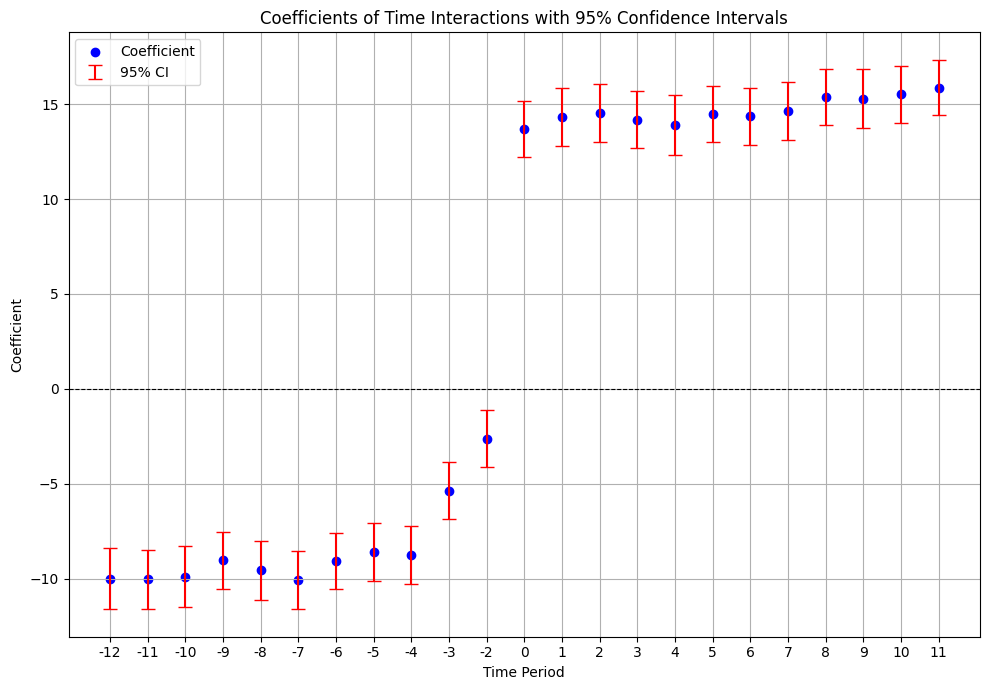

In [145]:
plot_ci_coeff(fe_model.params, fe_model.conf_int())

In [146]:
len(X.columns)

23

In [155]:
# Get the names of the pre-treatment coefficient variables
pre_treatment_vars = [f"time({i})" for i in range(-12,-1)]

formula = ""

for i in pre_treatment_vars:
    formula += i+" ="
formula += " "+"0"

wald_res = fe_model.wald_test(formula= formula)
print("Formula used for the Wald test \n", formula)
print("\n Results \n", wald_res)

Formula used for the Wald test 
 time(-12) =time(-11) =time(-10) =time(-9) =time(-8) =time(-7) =time(-6) =time(-5) =time(-4) =time(-3) =time(-2) = 0

 Results 
 Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 386.4717
P-value: 0.0000
Distributed: chi2(11)


In [110]:
formula

'time_(-12)_interaction =time_(-11)_interaction =time_(-10)_interaction =time_(-9)_interaction =time_(-8)_interaction =time_(-7)_interaction =time_(-6)_interaction =time_(-5)_interaction =time_(-4)_interaction =time_(-3)_interaction =time_(-2)_interaction = 0'

In [156]:
import numpy as np

# Identify the names of the pre-treatment coefficient variables
# Adjust this list based on your actual pre-treatment variable names
pre_treatment_vars = [
    col for col in fe_model.params.index if 'time_' in col and '_interaction' in col and int(col.split('_')[1].replace('(', '').replace(')', '')) < 0
]

# Assuming 'fe_model' is your fitted PanelOLS model results object
if pre_treatment_vars:
    # Ensure all specified pre-treatment variables are actually in the results
    available_pre_treatment_vars = [var for var in pre_treatment_vars if var in fe_model.params.index]

    if available_pre_treatment_vars:
        # Create the restriction matrix for the Wald test
        num_restrictions = len(available_pre_treatment_vars)
        restriction = np.eye(num_restrictions)

        # Get the indices of the pre-treatment variables in the params array
        param_indices = [list(fe_model.params.index).index(var) for var in available_pre_treatment_vars]

        # Perform the Wald test
        f_test = fe_model.wald_test(restriction, indices=param_indices, names=available_pre_treatment_vars)
        print("\nJoint Significance Test of Pre-Treatment Coefficients (Wald Test):")
        print(f_test)
    else:
        print("\nNo specified pre-treatment coefficients found in the model results.")
else:
    print("\nNo pre-treatment coefficients defined for the joint test.")


No pre-treatment coefficients defined for the joint test.


In [157]:
fe_model_log = PanelOLS(y_log, X, entity_effects=True, time_effects=True).fit(cov_type= "clustered", cluster_entity = True)
fe_model_log

Dep. Variable:,log_productivity,R-squared:,0.3946
Estimator:,PanelOLS,R-squared (Between):,0.0096
No. Observations:,48000,R-squared (Within):,0.5159
Date:,"Thu, Apr 17 2025",R-squared (Overall):,0.0100
Time:,14:31:06,Log-likelihood,5.22e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1302.4
Entities:,2000,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(23,45954)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,801.82


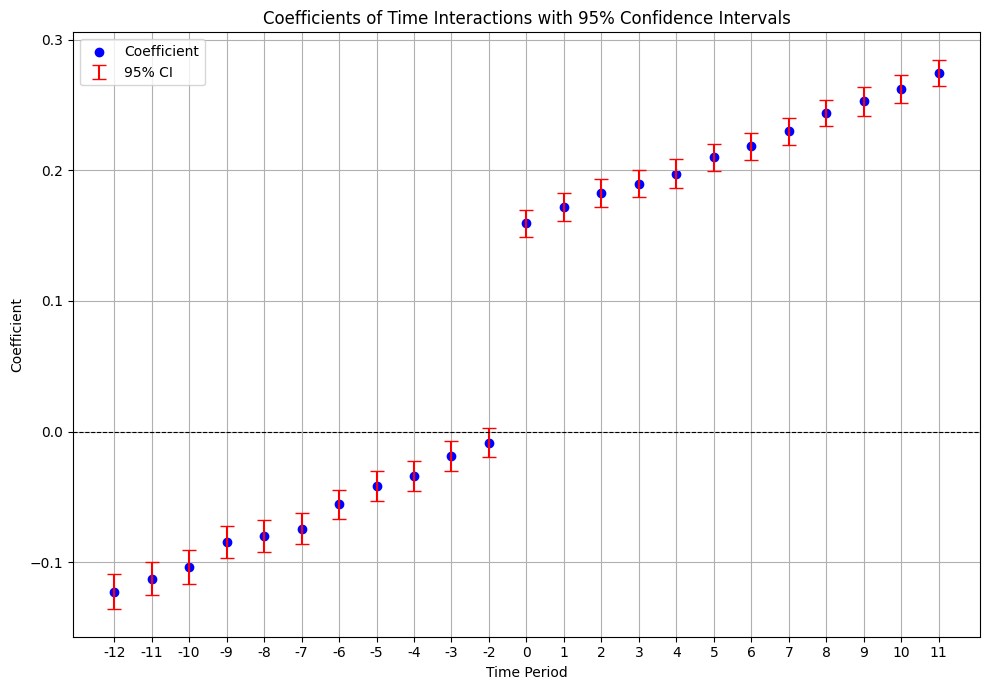

In [158]:
plot_ci_coeff(fe_model_log.params, fe_model_log.conf_int())

In [159]:
# Get the names of the pre-treatment coefficient variables
pre_treatment_vars = [f"time({i})" for i in range(-12,-1)]

formula = ""

for i in pre_treatment_vars:
    formula += i+" ="
formula += " "+"0"

wald_res = fe_model_log.wald_test(formula= formula)
print("Formula used for the Wald test \n", formula)
print("\n Results \n", wald_res)

Formula used for the Wald test 
 time(-12) =time(-11) =time(-10) =time(-9) =time(-8) =time(-7) =time(-6) =time(-5) =time(-4) =time(-3) =time(-2) = 0

 Results 
 Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 866.8435
P-value: 0.0000
Distributed: chi2(11)


### Part 4 - Placebo

Re-estimate the main specification (point 4 above) using as placebo treatment 2019Q3 (period 7).

In [172]:
fe_2way_data = data.reset_index().copy()
fe_2way_data["period"] += 13

fe_2way_data.loc[fe_2way_data["period"]>= 7, "post"] = 1
fe_2way_data["interaction_post"] = fe_2way_data["treat_group"]*fe_2way_data["post"]

fe_2way_data = fe_2way_data.set_index(["worker_id", "period"])

y_2way = fe_2way_data["productivity"]
X_2way = fe_2way_data["interaction_post"]

<Axes: xlabel='worker_id,period'>

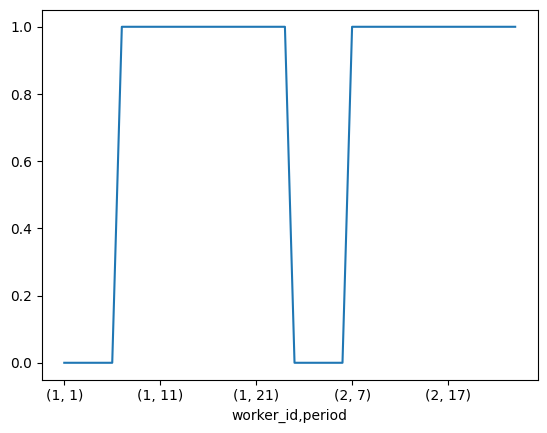

In [175]:
fe_2way_data.head(48)["post"].plot()

In [174]:
fe_model_placebo = PanelOLS(y_2way, X_2way, entity_effects=True, time_effects=True).fit(cov_type= "clustered", cluster_entity = True)
fe_model_placebo

Dep. Variable:,productivity,R-squared:,0.0887
Estimator:,PanelOLS,R-squared (Between):,0.0581
No. Observations:,48000,R-squared (Within):,0.1820
Date:,"Thu, Apr 17 2025",R-squared (Overall):,0.0597
Time:,14:42:37,Log-likelihood,-1.841e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,4473.8
Entities:,2000,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(1,45976)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,4684.6
